In [ ]:
#2nd part url: https://habr.com/ru/post/464823/
#https://api.hh.ru/areas - список регионов
#https://github.com/hhru/api - документация
#"'Data Analyst' or 'data scientist', not 'Директор'"
#https://api.hh.ru/specializations

In [1]:
import requests
import pandas as pd
import numpy as np

In [68]:


number_of_pages = 100
#number_of_ads = number_of_pages * per_page

job_title = ["'Психолог'"]
for job in job_title:
    data=[]
    for i in range(number_of_pages):
        url = 'https://api.hh.ru/vacancies'
        par = {'text': job, 'area':['1', '2', '66'],'per_page':'10', 'page':i, 'only_with_salary':True}
        r = requests.get(url, params=par)
        e=r.json()
        data.append(e)
        vacancy_details = data[0]['items'][0].keys()
        df = pd.DataFrame(columns= list(vacancy_details))
        ind = 0
        for i in range(len(data)):
            for j in range(len(data[i]['items'])):
                df.loc[ind] = data[i]['items'][j]
                ind+=1
    csv_name = "hh_base.csv"
    df.to_csv(csv_name)
   

In [69]:
hh_base = pd.read_csv('hh_base.csv')

In [70]:
hh_base

,Unnamed: 0,id,premium,name,department,has_test,response_letter_required,area,salary,type,...,alternate_url,relations,employer,snippet,contacts,schedule,working_days,working_time_intervals,working_time_modes,accept_temporary
0,0,50440323,False,Помощник психолога / психолог,NaN,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 60000, 'to': 105000, 'currency': 'RUR...","{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/vacancy/50440323,[],"{'id': '4780176', 'name': 'Фруктовый Регион', ...",{'requirement': 'Грамотная устная речь. - Проф...,NaN,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False
1,1,50427213,False,Психолог,NaN,False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...","{'from': 75000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/vacancy/50427213,[],"{'id': '5883333', 'name': 'Время Расцвета', 'u...",{'requirement': 'Опыт работы приветствуется. О...,NaN,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],True
2,2,50427638,False,Корпоративный психолог,NaN,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 80000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/vacancy/50427638,[],"{'id': '5450040', 'name': 'Red Rocks Coding', ...",{'requirement': 'Высшее психологическое образо...,NaN,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False
3,3,50407203,False,Медицинский психолог,NaN,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 50000, 'to': 60000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/vacancy/50407203,[],"{'id': '987387', 'name': 'ФГБУ Федеральное бюр...",{'requirement': 'Высшее профессиональное образ...,NaN,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False
4,4,50439547,False,Психолог в социальной сфере,NaN,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 54735, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/vacancy/50439547,[],"{'id': '2312541', 'name': 'ГБУ Центр социально...",{'requirement': 'высшее образование по профилю...,NaN,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,995,48698657,False,Воспитатель,NaN,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': 50000, 'to': None, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/vacancy/48698657,[],"{'id': '160642', 'name': 'Белфан', 'url': 'htt...",{'requirement': 'Знания <highlighttext>психоло...,NaN,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False
996,996,47053690,False,Тренинг-менеджер,"{'id': '51298-51298-petned', 'name': 'Петербур...",False,False,"{'id': '2', 'name': 'Санкт-Петербург', 'url': ...","{'from': 90000, 'to': 105000, 'currency': 'RUR...","{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/vacancy/47053690,[],"{'id': '51298', 'name': 'Петербургская Недвижи...",{'requirement': 'Законченное высшее психологич...,NaN,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False
997,997,50303237,False,Разработчик-аналитик (Data Engineer),NaN,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': None, 'to': 600000, 'currency': 'RUR'...","{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/vacancy/50303237,[],"{'id': '5174849', 'name': 'Wanted', 'url': 'ht...",{'requirement': 'Опыт разработки на Python. Хо...,NaN,"{'id': 'fullDay', 'name': 'Полный день'}",[],[],[],False
998,998,50295922,False,Медицинская сестра (ГЦ Жуковка),NaN,False,False,"{'id': '1', 'name': 'Москва', 'url': 'https://...","{'from': None, 'to': 76500, 'currency': 'RUR',...","{'id': 'open', 'name': 'Открытая'}",...,https://hh.ru/vacancy/50295922,[],"{'id': '985081', 'name': 'Senior Group', 'url'...","{'requirement': 'Медицинское образование, нали...",NaN,"{'id': 'flyInFlyOut', 'name': 'Вахтовый метод'}",[],[],[],False


In [71]:
hh_base = hh_base.drop(columns=['Unnamed: 0', 'premium', 'relations', 'contacts', 'working_days', 'working_time_intervals', 'working_time_modes', 'working_days', 'working_time_intervals', 'working_time_modes', 'apply_alternate_url', 'alternate_url', 'archived', 'response_url', 'address', 'response_letter_required', 'sort_point_distance', 'address'])

In [72]:
 import ast # run code from string for example ast.literal_eval("1+1") 

salaries = hh_base.salary.dropna() # remove all NA's from dataframe
currencies = [ast.literal_eval(salaries.iloc[i])['currency'] for i in range(len(salaries))]
curr = set(currencies) #{'EUR', 'RUR', 'USD'}

#divide dataframe salararies by currency
rur = [ast.literal_eval(salaries.iloc[i]) for i in range(len(salaries)) if ast.literal_eval(salaries.iloc[i])['currency']=='RUR']
eur = [ast.literal_eval(salaries.iloc[i]) for i in range(len(salaries)) if ast.literal_eval(salaries.iloc[i])['currency']=='EUR']
usd = [ast.literal_eval(salaries.iloc[i]) for i in range(len(salaries)) if ast.literal_eval(salaries.iloc[i])['currency']=='USD']
all = [ast.literal_eval(salaries.iloc[i]) for i in range(len(salaries))]

In [73]:
fr = [x['from'] for x in all] # lower range of salary
#fr = list(filter(lambda x: if x is not None x)) # remove NA's from lower range [0, 100, 200,...]

to = [x['to'] for x in all] #upper range of salary
#to = list(filter(lambda x: x is not None, to)) #remove NA's from upper range [100, 200, 300,...]

import numpy as np
#salary_range = list(zip(fr, to)) # concatenate upper and lower range  [(0,100), (100, 200), (200, 300)...]
#av = map(np.mean, salary_range) # convert [(0,100), (100, 200), (200, 300)...] to [50, 150, 250,...]
#for i in range(len(salary_range)):
    #salary_range[i] = round(np.mean(list(salary_range[i])),1) # average value from [50, 150, 250,...]



In [74]:
hh_base['salary_from'] = fr
hh_base['salary_to'] = to
hh_base = hh_base.drop(columns=['salary'])

In [75]:
employer_row = hh_base.loc[:,'employer']
employer = [ast.literal_eval(employer_row.iloc[i])['name'] for i in range(len(employer_row))]
all_empl = set(employer)

In [76]:
hh_base['employer'] = employer

In [77]:
comp = hh_base.groupby('employer').agg({'id' : 'count'})
comp = comp.sort_values(by='id', ascending=False)
top_10 = comp.head(10)
top_10

,id
employer,
ОМОН Главного управления Росгвардии по г. Москве,33
NewGen Vision,22
Петербургская Недвижимость,14
Точка,13
НБК Финанс,13
Semrush,12
Muglerest,12
Правое Полушарие Интроверта,10
Московская Служба Психологической Помощи Населению,9


In [78]:
area_row = hh_base.loc[:,'area']
area = [ast.literal_eval(area_row.iloc[i])['name'] for i in range(len(area_row))]
all_areas = set(area)

In [79]:
hh_base['area']= area

In [80]:
hh_base.groupby(by='name').agg({'id' : 'count'}).sort_values(by='id', ascending=False).head(10)

,id
name,
Психолог,21
Педагог-психолог,16
Менеджер по персоналу,11
Менеджер по продажам,11
Нейропсихолог,10
Менеджер по подбору персонала,10
Воспитатель,10
Воспитатель детей дошкольного возраста,9
Менеджер по работе с клиентами,7


In [81]:
hh_base.groupby(by='area').agg({'id' : 'count'})

,id
area,
Москва,677
Нижний Новгород,64
Санкт-Петербург,259


In [90]:
hh_base.groupby('name', as_index=False).agg({'salary' : 'median', 'id': 'count'}).sort_values(by='id', ascending=False).head(50)


,name,salary,id
569,Психолог,34000.0,21
482,Педагог-психолог,32500.0,16
319,Менеджер по персоналу,70000.0,11
337,Менеджер по продажам,80000.0,11
418,Нейропсихолог,81250.0,10
329,Менеджер по подбору персонала,70000.0,10
172,Воспитатель,58500.0,10
190,Воспитатель детей дошкольного возраста,50000.0,9
373,Менеджер по работе с клиентами,57500.0,7
421,Няня,70000.0,7


In [66]:
hh_base[hh_base['name'] == 'NLP разработчик']

,id,name,department,has_test,area,type,published_at,created_at,insider_interview,url,employer,snippet,schedule,accept_temporary,salary


In [83]:
describe = hh_base.loc[:,'snippet']
requirement = [ast.literal_eval(describe.iloc[i])['requirement'] for i in range(len(describe))]
hh_base['snippet'] = requirement

In [84]:
hh_base['salary'] = (hh_base['salary_from'] + hh_base['salary_to']) / 2

In [85]:
hh_base.loc[:,['salary_from','salary_to']] = hh_base.loc[:,['salary_from','salary_to']].fillna(0)
hh_base['sum_sal'] = hh_base['salary_from'] + hh_base['salary_to']

In [86]:
hh_base['salary'] = hh_base['salary'].fillna(value=hh_base['sum_sal'])

In [74]:
hh_base['salary'].isna().value_counts()

False    2000
Name: salary, dtype: int64

In [87]:
hh_base = hh_base.drop(columns=['sum_sal', 'salary_from','salary_to'])


In [88]:
schedule = hh_base.loc[:,'schedule']
schedule = [ast.literal_eval(schedule.iloc[i])['name'] for i in range(len(schedule))]
hh_base['schedule'] = schedule

In [89]:
hh_base['schedule'].value_counts()

Полный день         657
Удаленная работа    153
Гибкий график        95
Сменный график       90
Вахтовый метод        5
Name: schedule, dtype: int64

In [2]:
export_csv = hh_base.to_csv(r'hh_formatted.csv', index=None, header=True)

NameError: name 'hh_base' is not defined

In [87]:
hh_base = hh_base.drop(columns=['accept_temporary','has_test'])

KeyError: "['accept_temporary' 'has_test'] not found in axis"

In [2]:
hh_base = pd.read_csv('hh_formatted.csv')
hh_base.dtypes

id                     int64
name                  object
department            object
area                  object
type                  object
published_at          object
created_at            object
insider_interview     object
url                   object
employer              object
snippet               object
schedule              object
salary               float64
dtype: object

In [3]:
#sql
import sqlite3
conn = sqlite3.connect('hh.sqlite')
cur = conn.cursor()

In [6]:
cur.executescript('''


CREATE TABLE hh_base (
    id                     INTEGER,
name                  TEXT,
department            TEXT,
area                  TEXT,
type                  TEXT,
published_at          TEXT,
created_at            TEXT,
insider_interview     TEXT,
url                   TEXT,
employer              TEXT,
snippet               TEXT,
schedule              TEXT,
salary               REAL
);
''')

In [5]:
cur.executescript('''DROP TABLE hh_base;''')

In [7]:
for i in range(hh_base.shape[0]):
    print(i, end = ' ')
    cur.execute('''
    INSERT INTO hh_base (
            id,
            name,
            department,
            area,
            type,
            published_at,
            created_at,
            insider_interview,
            url,
            employer ,
            snippet,
            schedule ,
            salary         
                    )
    VALUES(?,?,?,?,?,?,?,?,?,?,?,?,?);''', # 13 столбцов
            (int(hh_base.iloc[i,0]),
             hh_base.iloc[i,1],
             hh_base.iloc[i,2],
             hh_base.iloc[i,3],
             hh_base.iloc[i,4],
             hh_base.iloc[i,5],
             hh_base.iloc[i,6],
             hh_base.iloc[i,7],
             hh_base.iloc[i,8],
             hh_base.iloc[i,9],
             hh_base.iloc[i,10],
             hh_base.iloc[i,11],
             hh_base.iloc[i,12]
             )) 

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

1894 1895 1896 1897 1898 1899 1900 1901 1902 1903 1904 1905 1906 1907 1908 1909 1910 1911 1912 1913 1914 1915 1916 1917 1918 1919 1920 1921 1922 1923 1924 1925 1926 1927 1928 1929 1930 1931 1932 1933 1934 1935 1936 1937 1938 1939 1940 1941 1942 1943 1944 1945 1946 1947 1948 1949 1950 1951 1952 1953 1954 1955 1956 1957 1958 1959 1960 1961 1962 1963 1964 1965 1966 1967 1968 1969 1970 1971 1972 1973 1974 1975 1976 1977 1978 1979 1980 1981 1982 1983 1984 1985 1986 1987 1988 1989 1990 1991 1992 1993 1994 1995 1996 1997 1998 1999 

In [8]:
cur.execute('''
select area as Город, avg(salary) as Средняя_зарплата
from hh_base
group by area
;
''')
pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])


,Город,Средняя_зарплата
0,Москва,118721.664008
1,Нижний Новгород,120444.666667
2,Санкт-Петербург,114651.752033


In [9]:
cur.execute('''
select id,
            name,
            department,
            area,
            type,
            published_at,
            created_at,
            insider_interview,
            url,
            employer ,
            snippet,
            schedule ,
            salary    
from hh_base
where name like 'Financ%' or name like 'Финанс%' or name like '%финанс%' or name like '%financ%' or name like 'финанс%' or name like 'financ%'
order by salary;
''')
finansists = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
export_csv = finansists.to_csv(r'finansists.csv', index=None, header=True)

In [72]:
finansists

,id,name,department,area,type,published_at,created_at,insider_interview,url,employer,snippet,schedule,salary
0,49732728,Старший финансовый аналитик,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2021-12-08T22:59:06+0300,2021-12-08T22:59:06+0300,None,https://api.hh.ru/vacancies/49732728?host=hh.ru,Стандарт Капитал,"...МСФО, РСБУ), <highlighttext>анализа</highli...",Удаленная работа,100000.0
1,49892073,Финансовый менеджер / Экономист,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2021-12-08T20:49:54+0300,2021-12-08T20:49:54+0300,None,https://api.hh.ru/vacancies/49892073?host=hh.ru,Малов Артём Сергеевич,"Опыт работы с P&L в розничных продажах, с обор...",Удаленная работа,150000.0
2,50314028,Финансовый директор / Заместитель финансового ...,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2021-12-08T20:44:15+0300,2021-12-08T20:44:15+0300,None,https://api.hh.ru/vacancies/50314028?host=hh.ru,Федоров Сергей Александрович,Опыт работы не менее 5 лет в сфере в должности...,Полный день,215000.0
3,50046258,Финансовый директор (релокация),None,Санкт-Петербург,"{'id': 'open', 'name': 'Открытая'}",2021-12-08T20:01:33+0300,2021-12-08T20:01:33+0300,None,https://api.hh.ru/vacancies/50046258?host=hh.ru,Наумова Ольга Николаевна,Опыт работы финансовым директором от 3-х лет. ...,Полный день,60000.0
4,49556378,Финансовый аналитик,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2021-12-08T19:59:28+0300,2021-12-08T19:59:28+0300,None,https://api.hh.ru/vacancies/49556378?host=hh.ru,Офисфлекс,Высшее образование со специализацией в области...,Гибкий график,180000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,49478021,Финансовый менеджер по работе с банками,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2021-11-09T18:00:06+0300,2021-11-09T18:00:06+0300,None,https://api.hh.ru/vacancies/49478021?host=hh.ru,АСПЕКТ ЛИЗИНГ,Опыт работы экономистом /бухгалтером/ финансов...,Полный день,30000.0
428,49464343,Управляющий финансами/Финансовый советник/Бизн...,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2021-11-09T13:21:13+0300,2021-11-09T13:21:13+0300,None,https://api.hh.ru/vacancies/49464343?host=hh.ru,Управляющая холдинговая компания,Опыт работы на аналогичной должности от 6 лет....,Полный день,90000.0
429,49463114,Помощник финансового менеджера (удалённо),None,Санкт-Петербург,"{'id': 'open', 'name': 'Открытая'}",2021-11-09T13:01:15+0300,2021-11-09T13:01:15+0300,None,https://api.hh.ru/vacancies/49463114?host=hh.ru,FutureSearch,Опыт работы <highlighttext>финансовым</highlig...,Удаленная работа,40000.0
430,49462089,Финансовый контролер,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2021-11-09T12:44:33+0300,2021-11-09T12:44:33+0300,None,https://api.hh.ru/vacancies/49462089?host=hh.ru,Связь Элемент,Знание 1С: Предприятие 8. - Умение работать с ...,Полный день,160000.0


In [10]:
cur.execute('''
select id,
            name,
            department,
            area,
            type,
            published_at,
            created_at,
            insider_interview,
            url,
            employer ,
            snippet,
            schedule ,
            salary    
from hh_base
where name like 'Data%' or name like '%данны%' or name like '%data%' or name like '%Data%' or name like '%Данны%' or name like '%Data'

;
''')
Data_scientists = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
export_csv = Data_scientists.to_csv(r'Data_scientists.csv', index=None, header=True)

In [11]:
Data_scientists

,id,name,department,area,type,published_at,created_at,insider_interview,url,employer,snippet,schedule,salary
0,49893238,Продуктовый аналитик/data аналитик (SQL),None,Москва,"{'id': 'open', 'name': 'Открытая'}",2021-12-08T23:58:03+0300,2021-12-08T23:58:03+0300,None,https://api.hh.ru/vacancies/49893238?host=hh.ru,Open Technologies Inc,Обязательно (реально на самом деле по правде о...,Удаленная работа,80000.0
1,49893238,Продуктовый аналитик/data аналитик (SQL),None,Москва,"{'id': 'open', 'name': 'Открытая'}",2021-12-08T23:58:03+0300,2021-12-08T23:58:03+0300,None,https://api.hh.ru/vacancies/49893238?host=hh.ru,Open Technologies Inc,Обязательно (реально на самом деле по правде о...,Удаленная работа,130000.0
2,50048134,Middle Data Engineer,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2021-12-08T23:09:14+0300,2021-12-08T23:09:14+0300,None,https://api.hh.ru/vacancies/50048134?host=hh.ru,Educate Online Inc,...<highlighttext>Data</highlighttext> <highli...,Удаленная работа,175000.0
3,49557719,Data Scientist (компьютерное зрение),None,Москва,"{'id': 'open', 'name': 'Открытая'}",2021-12-08T23:02:59+0300,2021-12-08T23:02:59+0300,None,https://api.hh.ru/vacancies/49557719?host=hh.ru,Дип Системс,Опыт успешного применение Deep Learning в зада...,Удаленная работа,100000.0
4,49218761,Big Data Engineer (Yellow Team),None,Санкт-Петербург,"{'id': 'open', 'name': 'Открытая'}",2021-12-08T22:17:14+0300,2021-12-08T22:17:14+0300,None,https://api.hh.ru/vacancies/49218761?host=hh.ru,Semrush,Опыт Big <highlighttext>Data</highlighttext>/H...,Полный день,52500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
262,49495200,Data Architect / Architect DS,None,Москва,"{'id': 'open', 'name': 'Открытая'}",2021-11-10T11:15:09+0300,2021-11-10T11:15:09+0300,None,https://api.hh.ru/vacancies/49495200?host=hh.ru,Сеть Партнерств,Высшее техническое образование. Опыт работы в ...,Полный день,200000.0
263,49487847,Администратор баз данных MS SQL,None,Санкт-Петербург,"{'id': 'open', 'name': 'Открытая'}",2021-11-10T09:03:27+0300,2021-11-10T09:03:27+0300,None,https://api.hh.ru/vacancies/49487847?host=hh.ru,Франчайзинговая розничная сеть Галамарт,Уверенные знания и практический опыт администр...,Полный день,77500.0
264,49467026,Специалист Computer Vision (Senior Data Scient...,None,Санкт-Петербург,"{'id': 'open', 'name': 'Открытая'}",2021-11-09T14:13:03+0300,2021-11-09T14:13:03+0300,None,https://api.hh.ru/vacancies/49467026?host=hh.ru,Медицинские Скрининг Системы,"Хочет работать в энергичной, слегка чокнутой к...",Полный день,70000.0
265,49462664,Инженер данных (Data Engineer),None,Москва,"{'id': 'open', 'name': 'Открытая'}",2021-11-09T12:52:43+0300,2021-11-09T12:52:43+0300,None,https://api.hh.ru/vacancies/49462664?host=hh.ru,Колесо,...баз <highlighttext>данных</highlighttext> и...,Удаленная работа,40000.0


In [16]:
cur.execute('''
select 
            area,
            schedule as 'Режим работы' ,
            count(schedule) as 'Кол-во вакансий' 
from hh_base
group by area, schedule
;
''')
schedule = pd.DataFrame(cur.fetchall(), columns=[desc[0] for desc in cur.description])
export_csv = schedule.to_csv(r'schedule.csv', index=None, header=True)

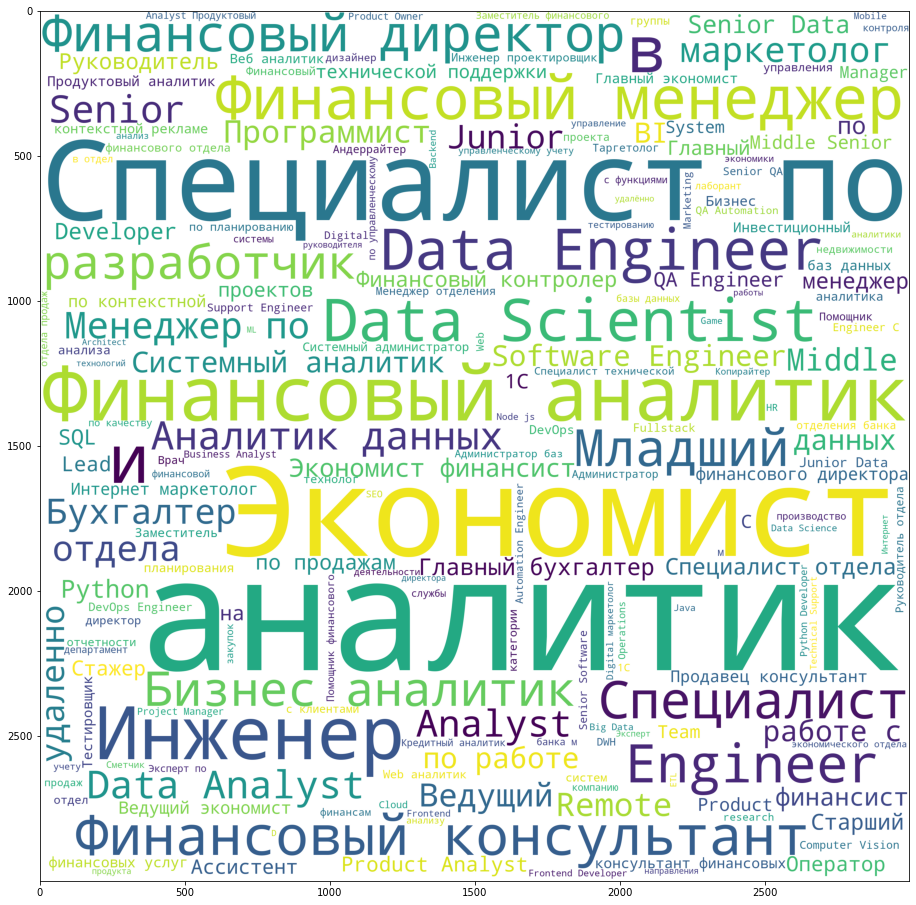

In [84]:
#сравниваем таблицы: исходную и обработанные в SQL
from collections import Counter

vacancy_names =  hh_base.name # change here to change source of data/words etc
cloud = Counter(vacancy_names)
from wordcloud import WordCloud, STOPWORDS

cloud = ''
for x in list(vacancy_names):
    cloud+=x+' '
wordcloud = WordCloud(width = 3000, height = 3000, 

                stopwords = stopwords, 
                min_font_size = 2,background_color='white'
                     ).generate(cloud)

import matplotlib.pylab as plt
plt.figure(figsize = (16, 16)) 
plt.imshow(wordcloud)
plt.savefig('hh_cloud.png')

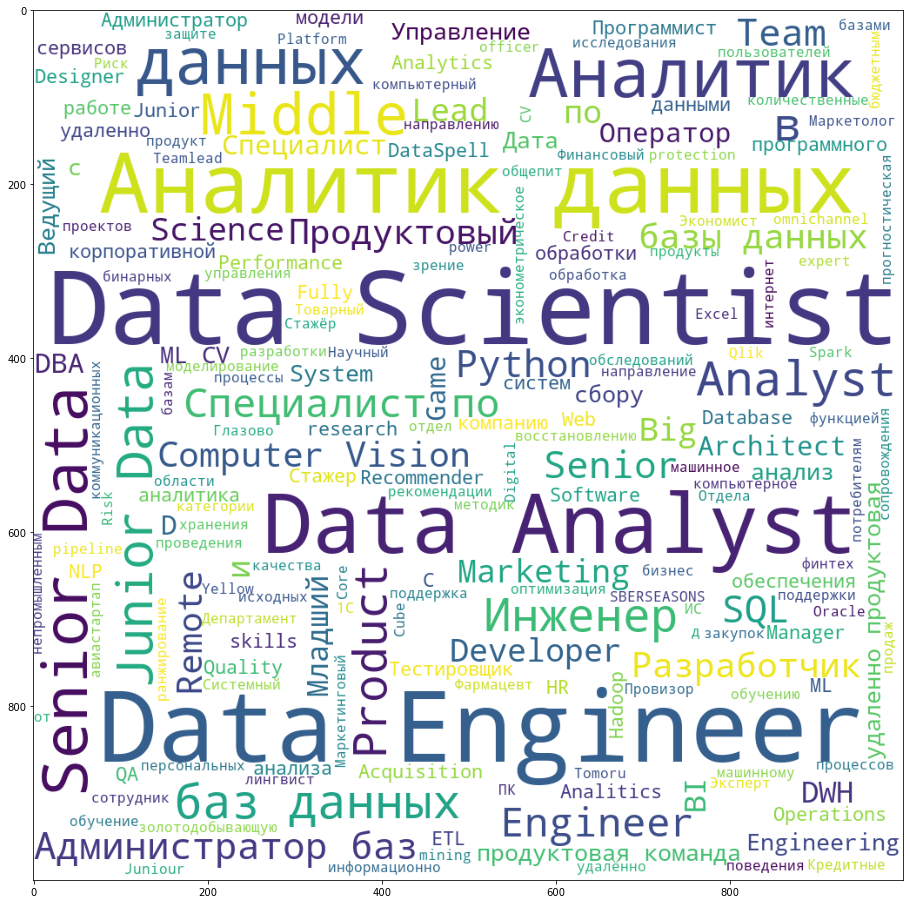

In [86]:
from collections import Counter

vacancy_names =  Data_scientists.name # change here to change source of data/words etc
cloud = Counter(vacancy_names)
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
cloud = ''
for x in list(vacancy_names):
    cloud+=x+' '
wordcloud = WordCloud(width = 1000, height = 1000, 

                stopwords = stopwords, 
                min_font_size = 8,background_color='white'
                     ).generate(cloud)

import matplotlib.pylab as plt
plt.figure(figsize = (16, 16)) 
plt.imshow(wordcloud)
plt.savefig('Data scientists_cloud.png')

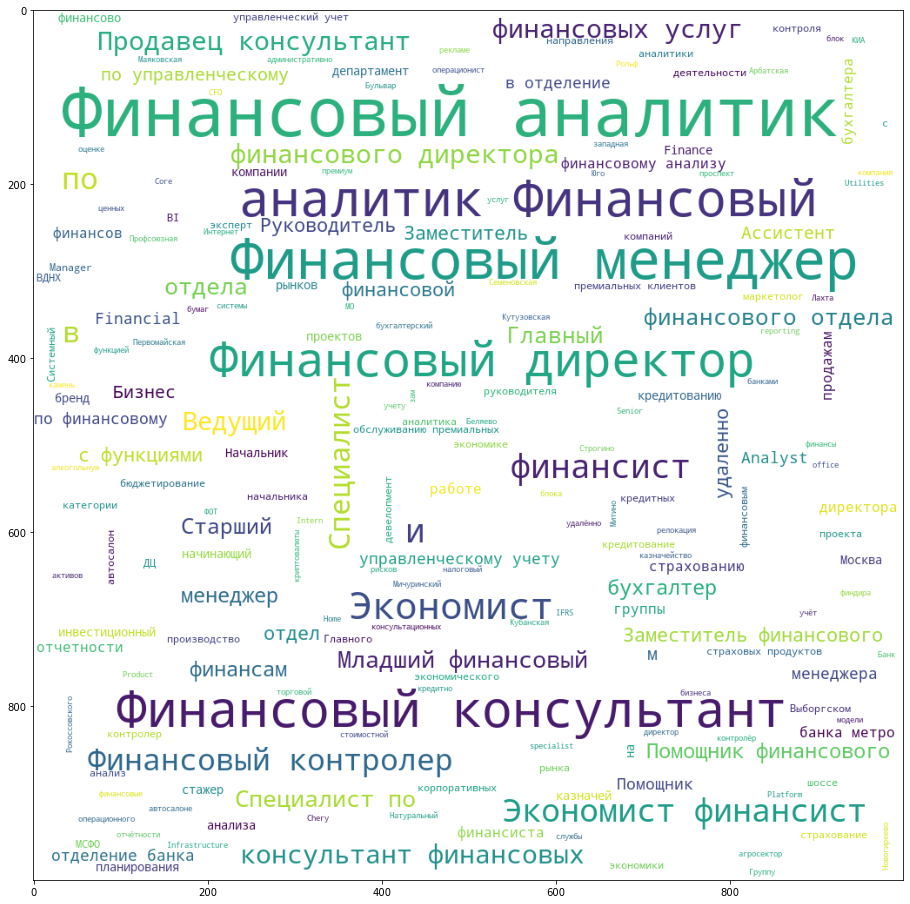

In [126]:
from collections import Counter

vacancy_names =  finansists.name # change here to change source of data/words etc
cloud = Counter(vacancy_names)
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
cloud = ''
for x in list(vacancy_names):
    cloud+=x+' '
wordcloud = WordCloud(width = 1000, height = 1000, 

                stopwords = stopwords, 
                min_font_size = 8,background_color='white'
                     ).generate(cloud)

import matplotlib.pylab as plt
plt.figure(figsize = (16, 16)) 
plt.imshow(wordcloud)
plt.savefig('finansists_cloud.png')

In [100]:
import seaborn as sns



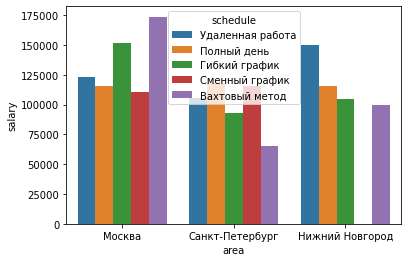

In [150]:

sns.barplot(
    x="area", 
    y="salary", 
    hue='schedule',
    ci=None,
    capsize=0.001,
    data=hh_base
);

plt.savefig('hh_salaries.png')

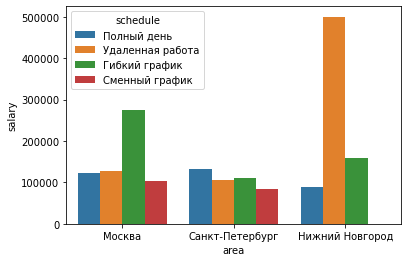

In [330]:
sns.barplot(
    x="area", 
    y="salary", 
    hue='schedule',
    ci=None, 
    data=finansists,
    capsize=0.8
);
plt.savefig('fin_salaries.png')

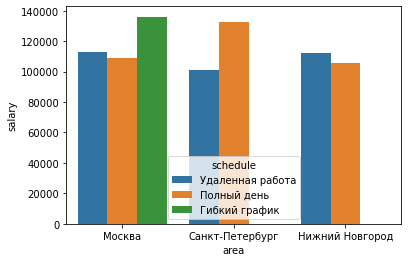

In [331]:
sns.barplot(
    x="area", 
    y="salary", 
    hue='schedule',
    ci=None, 
    
    data=Data_scientists
);

plt.savefig('Data_salaries.png')

In [3]:
lst_no = ['.', ',', ':', '!', '"', "'", '[', ']', '-', '—', '(', ')', '?', '_', '`', '<', '>' ]   # и т.д.
lst = []

for word in str(list(hh_base['snippet'])).lower().split():
    if not word in lst_no:
        _word = word 
        if word[-1] in lst_no:
            _word = _word[:-1]
        if word[0] in lst_no:
            _word = _word[1:] 
        lst.append(_word)

_dict = dict()
for word in lst:
    _dict[word] = _dict.get(word, 0) + 1

# сортируем словарь посредством формирования списка (значение, ключ)
_list = []
for key, value in _dict.items():
    _list.append((value, key))
    _list.sort(reverse=True)

# самое частое слово в этом тексте
print(f'самое частое слово в этом тексте -> `{_list[0][1]}`, использовалось `{_list[0][0]}` раз.')

самое частое слово в этом тексте -> `опыт`, использовалось `1490` раз.


In [274]:
_list

[(1490, 'опыт'),
 (1334, 'и'),
 (1140, 'работы'),
 (1042, 'в'),
 (825, 'знание'),
 (675, 'с'),
 (632, ''),
 (484, 'образование'),
 (443, 'высшее'),
 (358, 'от'),
 (332, 'умение'),
 (324, 'на'),
 (320, 'лет'),
 (317, 'highlighttext>данных</highlighttext>'),
 (231, 'highlighttext>анализа</highlighttext'),
 (230, 'по'),
 (218, 'или'),
 (218, 'highlighttext>данных</highlighttext'),
 (215, 'excel'),
 (197, 'работать'),
 (187, 'навыки'),
 (174, 'понимание'),
 (169, 'experience'),
 (163, 'учета'),
 (160, 'highlighttext>data</highlighttext'),
 (143, 'ms'),
 (140, 'пользователь'),
 (138, 'sql'),
 (137, 'не'),
 (135, 'of'),
 (127, 'знания'),
 (126, 'and'),
 (124, 'владение'),
 (118, 'сфере'),
 (118, 'будет'),
 (115, 'бухгалтерского'),
 (112, 'in'),
 (109, 'должности'),
 (107, 'экономическое'),
 (107, 'желание'),
 (106, 'области'),
 (106, 'python'),
 (105, 'года'),
 (104, '1'),
 (102, 'основ'),
 (101, 'принципов'),
 (99, 'менее'),
 (98, '1с'),
 (96, 'для'),
 (95, 'разработки'),
 (95, '3'),
 (94, 

In [28]:
def word_trans(text):
    text = str(list(hh_base['snippet']))
    text = text.lower()
    spec_chars = string.punctuation + '...n' + 'highlighttext'
    text = "".join([ch for ch in text if ch not in spec_chars])
    len(text)

In [ ]:
from nltk import word_tokenize
text_tokens = word_tokenize(text)
len(text_tokens)

In [288]:
import nltk
text = nltk.Text(text_tokens)

In [289]:
from nltk.probability import FreqDist
fdist = FreqDist(text)

In [9]:
import string
text

'обязательно реально на самом деле по правде обязательно без исключений умение читать писать и говорить поанглийски задачи будут ставить обязательно реально на самом деле по правде обязательно без исключений умение читать писать и говорить поанглийски задачи будут ставить daa r от 2 лет отличное знание sq опыт работы с реляционными базами данных posrsqmysq с аналитической базой данных опыт успешного применение dp ar в задачах компьютерного зрения уверенное знание pyo u  opcv pyorc английский как минимум  чтение мсфо рсбу анализа финансовохозяйственной деятельности предприятия опыт участия в сделках ma высокий уровень навыков финансового анализа и моделирования  coavs prc  pormpor daa pps prc  procss u amou of daa prks of work w опыт b daaoad проектах опыт работы с cckous знания и опыт с одиннескольким языками pyo c oa  высшее образование степень бакалаврамагистра по направлениям маркетинг социология экономика опыт работы в сфере аналитики маркетинговых исследований и опыт проведения хо

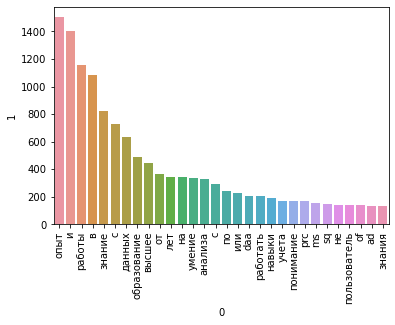

In [324]:
import matplotlib.pyplot as plt
import numpy as np
most_common = pd.DataFrame(fdist.most_common(30))
x=most_common.loc[:,0]
y=most_common.loc[:,1]
plot = sns.barplot(x=x, y=y)
labels = plot.set_xticklabels(x, rotation=90)
plt.savefig('Skills_bar.png')

In [292]:
len(text)

36745

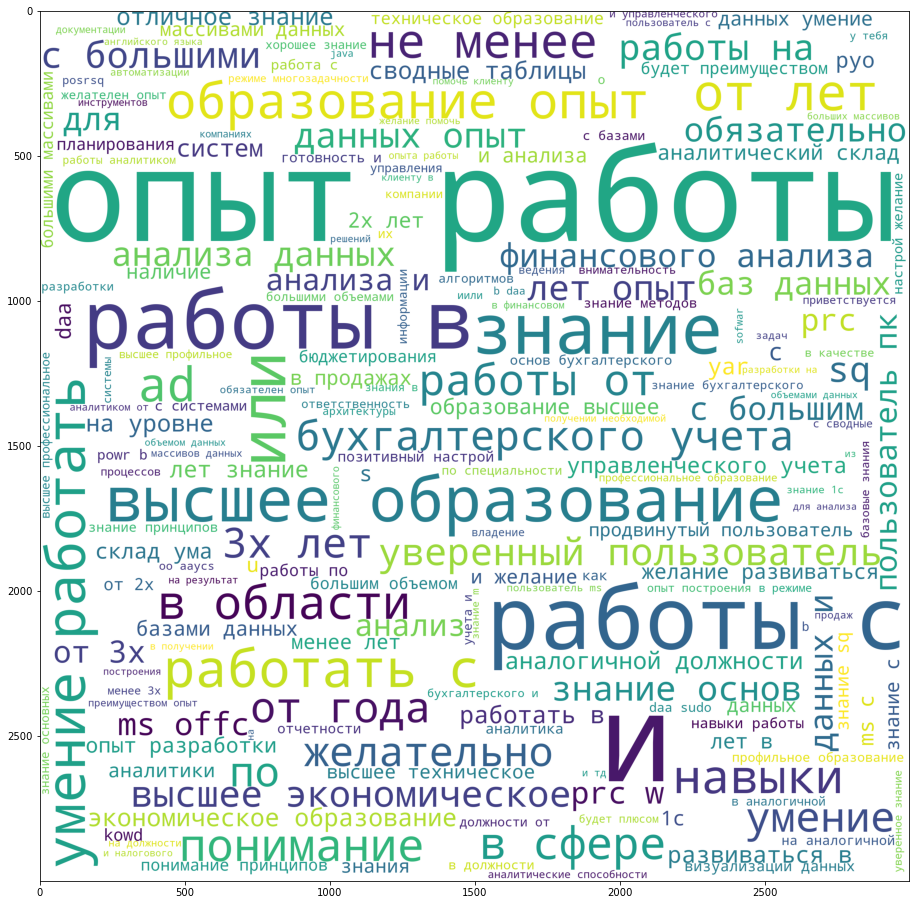

In [325]:
from collections import Counter

skills =  text_tokens # change here to change source of data/words etc
cloud = Counter(skills)
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)
cloud = ''
for x in list(skills):
    cloud+=x+' '
wordcloud = WordCloud(width = 3000, height = 3000, 

                stopwords = stopwords, 
                min_font_size = 2,background_color='white'
                     ).generate(cloud)

import matplotlib.pylab as plt
plt.figure(figsize = (16, 16)) 
plt.imshow(wordcloud)
plt.savefig('skills.png')

In [3]:
#https://pandas-profiling.github.io/pandas-profiling/docs/master/index.html
from pandas_profiling import ProfileReport

In [6]:
profile = ProfileReport(hh_base, title="Статистика по вакансиям Data Scientists и Финансовый аналитик в НН, СПБ и МСК", explorative=True)
profile.to_widgets()

In [7]:
profile.to_file("hh_report.html")

In [ ]:
#words

In [35]:
monkey_skills = ['Уровень знания английского: upper intermediate',
'Уверенный пользователь ПК (Microsoft Office: Excel, Word, PowerPoint)',
'Грамотная устная и письменная речь',
'Владение Python. Библиотеки: scikit-learn, numpy, pandas, matplotlib.',
'SQL',
'Eviews',
'Корпоративные финансы', 'эконометрика'
]

In [41]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/bert-base-nli-mean-tokens')

In [32]:
#библиотека схожести векторов текста
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords

In [33]:
import re
from nltk import word_tokenize


In [65]:
#преобразование предложений в вектора
candidate_skills = tokenizer.encode(str(monkey_skills),  max_length=2000, truncation=True, padding='max_length', return_tensors='pt')
candidate_skills

tensor([[ 101, 1031, 1005,  ...,    0,    0,    0]])

In [75]:
text_list = list(hh_base['snippet'])
import string
spec_chars = string.punctuation + '...n' + 'highlighttext'
for i in range(len(text_list)):
    text_list[i] = str(text_list[i])
    text_list[i] = "".join([ch for ch in text if ch not in spec_chars])



NameError: name 'text' is not defined

In [80]:
text_list = list(hh_base['snippet'])
import string
spec_chars = string.punctuation + '...n' + 'highlighttext'
for i in range(len(text_list)):
    text_list[i] = str(text_list[i])

In [81]:
for i in range(len(text_list)):    
    text_list[i] = "".join([ch for ch in text_list[i] if ch not in spec_chars])

In [78]:
for i in range(len(text_list)):
    text_list[i] = word_tokenize(text_list[i])

In [82]:
for i in range(len(text_list)):
    text_list[i] = tokenizer.encode(text_list[i], max_length=2000, truncation=True, padding='max_length', return_tensors='pt')

In [85]:

for i in range(len(text_list)):
    text_list[i] = cosine_similarity(candidate_skills,text_list[i])

In [53]:
text_list = pd.DataFrame(text_list).fillna(value='Нет данных')
text_list = list(text_list)

In [86]:
text_list = pd.DataFrame(text_list)

ValueError: Must pass 2-d input. shape=(2000, 1, 1)

In [87]:
hh_base['similarity'] = text_list

In [96]:
top_suitable = hh_base.sort_values(by='similarity', ascending=False).head(100)
export_csv = top_suitable.to_csv(r'top_suitable.csv', index=None, header=True)